# Pydata Bristol 2019-11-21
## "Getting geospatial work done with the pydata stack"

`Geospatial data` broadly refers to data that includes some kind of `geographic or location` information.  

This is a quick run through of a useful package [geopandas](http://geopandas.org/), which extends the popular pandas library for geospatial tasks.

Gonna look a some toy examples of visualisation and simple spatial analysis.

In [1]:
import geopandas as gpd
import descartes
%matplotlib inline

# let's import some toy geospatial data and take a look
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# checking out the 'special' geometry column (in well known text format)
countries.head(10)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."
5,18556698,Asia,Kazakhstan,KAZ,460700.0,"POLYGON ((87.35997033076265 49.21498078062912,..."
6,29748859,Asia,Uzbekistan,UZB,202300.0,"POLYGON ((55.96819135928291 41.30864166926936,..."
7,6909701,Oceania,Papua New Guinea,PNG,28020.0,(POLYGON ((141.0002104025918 -2.60015105551566...
8,260580739,Asia,Indonesia,IDN,3028000.0,(POLYGON ((141.0002104025918 -2.60015105551566...
9,44293293,South America,Argentina,ARG,879400.0,(POLYGON ((-68.63401022758323 -52.636370458874...


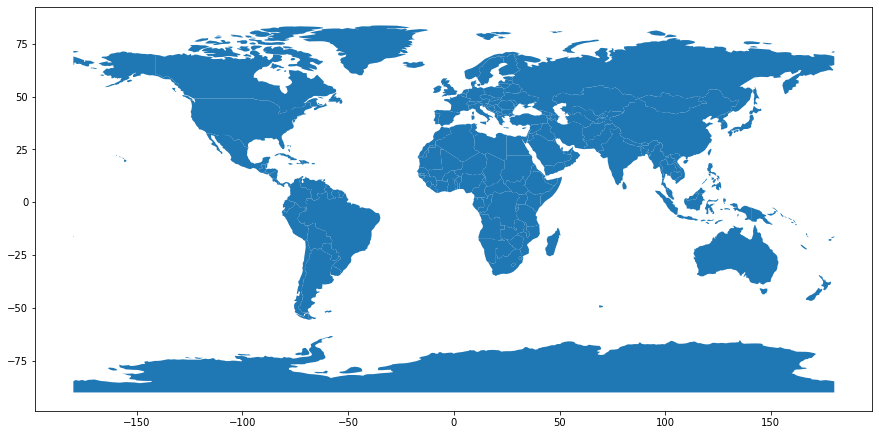

In [2]:
# geopandas wraps matplotlib, notice geographic coords (based on the data are used)
countries.plot(figsize=(15,10));

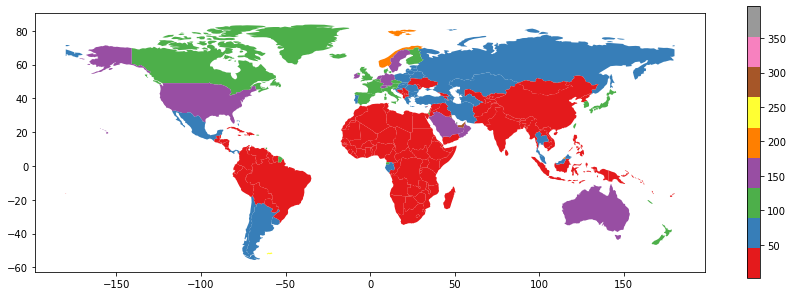

In [3]:
# let's do a nice, more useful plot, map nerds get ready for a chloropeth map

# convert country population + country gdp to gdp/capita/day and make a chloropleth map
countries['gdp_ph_day'] = ((countries.gdp_md_est * 1000000) / countries.pop_est) / 365

# plot it - and drop Antarctica (sorry!)
countries[(countries.continent != 'Antarctica') & (countries.continent != 'Seven seas (open ocean)')].plot(
    figsize=(15,5), cmap='Set1', column='gdp_ph_day', legend=True);

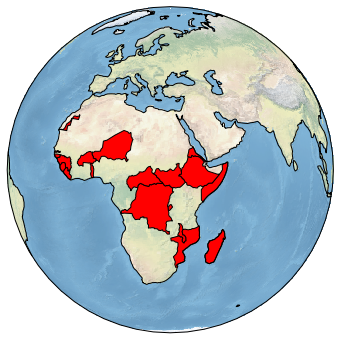

In [4]:
# geopandas plays nice with cartopy, which adds a rich set of cartographic visualisation features
# like plotting on a globe. sweet.

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.Orthographic(30,10))
ax.stock_img()
countries[(countries.gdp_ph_day <= 5)].plot(ax=ax,color = 'red', edgecolor='black',transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE);

# viz = got it.

# let's do some analysis though

In [5]:
import pathlib
import pandas as pd
from geopandas import GeoDataFrame
from shapely.geometry import Point

# read in some crime CSV data to a pandas dataframe, and check it out
df = pd.read_csv(
    pathlib.Path.cwd() / 'data' / 'london-crime-data-july-2019.csv')
df.head(10)

,month,x,y,category,outcome
0,2019-07,-0.236275,51.491752,Anti-social behaviour,NaN
1,2019-07,-0.237655,51.491827,Bicycle theft,Under investigation
2,2019-07,-0.239502,51.490623,Burglary,Under investigation
3,2019-07,-0.240270,51.491237,Other theft,Under investigation
4,2019-07,-0.238443,51.491560,Vehicle crime,Under investigation
5,2019-07,-0.239068,51.491030,Vehicle crime,Under investigation
6,2019-07,-0.240270,51.491237,Vehicle crime,Under investigation
7,2019-07,-0.236728,51.490446,Vehicle crime,Under investigation
8,2019-07,-0.237655,51.491827,Vehicle crime,Under investigation
9,2019-07,-0.236275,51.491752,Vehicle crime,Under investigation


In [6]:
# convert the regular pandas dataframe to geopandas 'GeoDataFrame'.
crime_df = GeoDataFrame(
    df.drop(['x', 'y'], axis=1),
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(df.x,df.y)])
crime_df.head(5)

,month,category,outcome,geometry
0,2019-07,Anti-social behaviour,NaN,POINT (-0.236275 51.49175200000001)
1,2019-07,Bicycle theft,Under investigation,POINT (-0.237655 51.491827)
2,2019-07,Burglary,Under investigation,POINT (-0.239502 51.490623)
3,2019-07,Other theft,Under investigation,POINT (-0.24027 51.491237)
4,2019-07,Vehicle crime,Under investigation,POINT (-0.238443 51.49156)


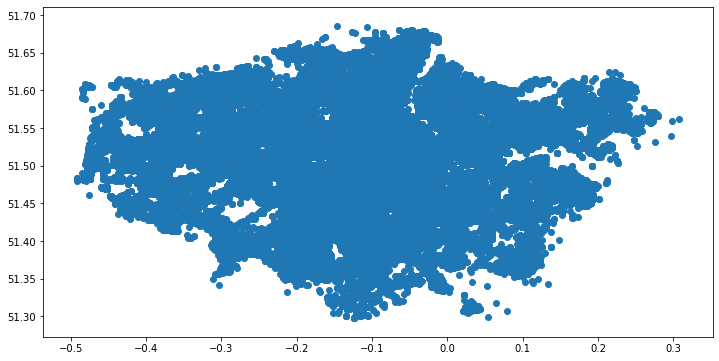

In [7]:
crime_df.plot(figsize=(12,10));

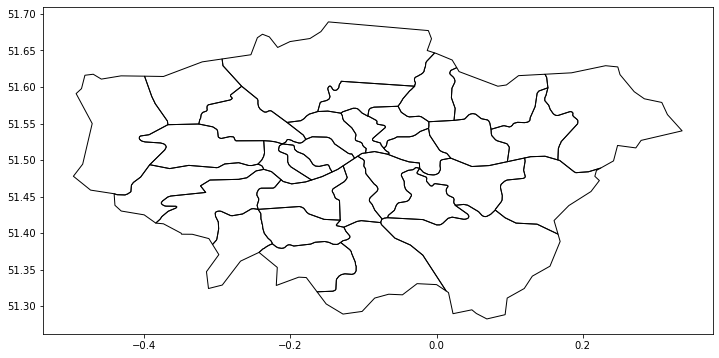

In [8]:
# we want to aggregate our crime data using some geographic adminstrative areas, let's do it.
london_boroughs = gpd.read_file(
    pathlib.Path.cwd() / 'data' / 'london-boroughs.shp',
    index='name')
london_boroughs.plot(figsize=(12,10),facecolor="none",edgecolor='black');

In [9]:
# let's join the crime dataset with the 'admin' area dataset, using 'sjoin' method of geopandas
joined_crime_data = london_boroughs.merge(
    gpd.sjoin(
    crime_df, london_boroughs, op='intersects', how='right').groupby(
    ['name','category'])['name'].count().unstack(),
    on='name')
joined_crime_data.head(3)

,name,geometry,Anti-social behaviour,Bicycle theft,Burglary,Criminal damage and arson,Drugs,Other crime,Other theft,Possession of weapons,Public order,Robbery,Shoplifting,Theft from the person,Vehicle crime,Violence and sexual offences
0,Wandsworth,POLYGON ((-0.1317176988127358 51.4176887067683...,858,90,264,129,125,18,296,14,153,55,115,67,302,653
1,Waltham Forest,POLYGON ((0.02762657980281347 51.6264614940027...,661,71,129,134,158,20,189,5,108,65,54,57,301,508
2,Tower Hamlets,POLYGON ((0.01943586577255019 51.5025930851027...,1452,96,226,135,156,35,300,19,182,81,77,80,242,710


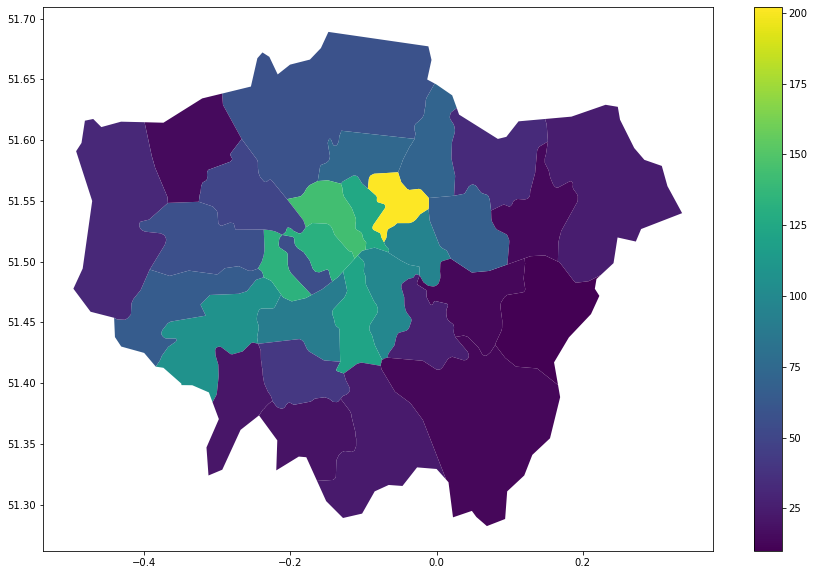

In [10]:
# plot the aggregation result in a chloropeth map
joined_crime_data.plot(column='Bicycle theft', legend=True, figsize=(15,10)).set_aspect('auto')

# what just happened ...

* use geopandas to visualise tabular location data quickly
* get fancy with your geopandas data with projections using cartopy
* use geopanadas to do some 'spatial joining' of disperate datasets


# we're done, thanks


repo https://github.com/samfranklin/pydata-lightening-talk

contact https://twitter.com/SamRFranklin